# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [21]:
!g++ -o tp_openmp_part_1_pi_sequential part1/tp_openmp_part_1_pi_sequential.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_critical part1/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_reduce part1/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_atomic part1/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_n_reduction part1/tp_openmp_part_1_pi_impl_n_reduction.cpp -fopenmp -O3 -march=native


### Performance evaluation

In [22]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats.csv")
except OSError:
    pass

df = pd.DataFrame(columns=['version','nthread','num_steps','runtime'])
df.to_csv("stats_part1_seq.csv", index=False)

num_steps = [10000, 1000000, 10000000, 100000000]
nb_threads = [1, 2, 4, 8]
repeats = range(0,10)

for nsteps in num_steps:
    for nthread in nb_threads:
        for repeat in repeats:
            args = ("./tp_openmp_part_1_pi_sequential", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()
            
            args = ("./tp_openmp_part_1_pi_impl_critical", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            
            args = ("./tp_openmp_part_1_pi_impl_reduce", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_atomic", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()


            args = ("./tp_openmp_part_1_pi_impl_n_reduction", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()          



### Performance analysis

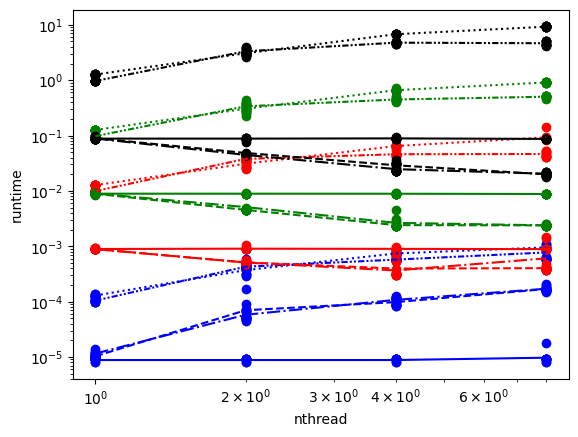

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread','num_steps','runtime'],dtype={
                     'version': str,
                     'nthread': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 10000000 : "green", 100000000 : "black"}

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "sequential"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps], label=f'{num_steps} sequential')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dotted",color=color_num_steps[num_steps], label=f'{num_steps} critical')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "atomic"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle=(0, (3, 1, 1, 1, 1, 1)),color=color_num_steps[num_steps], label=f'{num_steps} atomic')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps], label= f'{num_steps} reduce')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "n_reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashdot",color=color_num_steps[num_steps], label=f'{num_steps} n_reduce')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    
plt.xlabel('nthread')
plt.ylabel('runtime')

plt.legend()
plt.show()

### Discussion

#### Sequential
Le code séquentiel ne dépend pas du nombre de thread puisqu'il sera toujours exécuté sur un unique thread, c'est pour cela que le temps d'exécution est constant lorque le nombre de thread augmente. Néanmoins, étant donné que le thread exécutera toujours de la même façon le programme, lorsque le nombre de steps augmente il y a une augmentation du temps d'exécution.

#### Critical
Nous pouvons observer qu'en mettant une variable en critical le temps d'exécution va suivre la même évolution quelque soit le nombre de steps. En revanche, nous pouvons remarquer que lorsque le nombre de thread augmente, le temps d'éxécution va signicativement augmenter. Cela peut s'expliquer car la ressource critique va être demandée par de plus en plus de threads mais ne pourra çetre accessible que dans un seul thread à la fois, l'exécution sera donc stoppée dans tous les autres threads et ainsi ralentir le programme.

#### Atomic
Le passage d'une variable en atomic va avoir le même comportement que pour le critical mais le temps d'exécution sera moins ralenti que dans le critical. En effet, une section critique mettra tous les autres threads en pause tandis que le atomic fera uniquement un accès momentané à cette variable sans bloquer les autres threads car cette opération est gérée directement par le matériel.

#### Reduce
Concernant la méthode de réduce, les temps d'exécution ne semblent pas trop disparates, on peut apercevoir un gain de performance pour 10e5, 10e6 et 10e7 étapes lorsque que l'on augmente le nombre de thread.
Ce n'est pas le cas pour 10e3 étapes, où la tendance s'inverse, en effet il semblerait que dans ce cas, augmenter le nombre de thread détériore le temps d'exécution. Il semble que ce nombre de steps soit trop petit par rapport au découpage fait dans les différents threads, le temps d'exécution est donc ralenti par la création et la destruction des threads.

#### N reduce
Pour ce qui est de la méthode de n_reduce, on a à peu près les mêmes résultats, à l'exception du temps d'exécution de 10e5 étapes avec 8 threads, où il semble que celui-ci se détériore, de plus ou peut voir qu'à ce point-ci les temps d'exécution sont plus hétérogènes.
On semble atteindre un plateau plus rapidement qu'avec la méthode de reduce classique.

A TESTER AVEC PLUS DE COEUR

#### Conclusion
Finalement, nous avons pu voir que le séquentiel sera plus efficace qu'un programme en parallèle lorsqu'il y a peu de calculs à effectuer. Mais dès que le nombre de calculs à effectuer augmente le parallélisme sera plus efficace en général sauf avec l'utilisation de critical et atomic.
La méthode reduce semble être la plus pertinente pour obtenir de meilleures performances, dans le cadre de cette étude, à condition d'avoir un nombre assez important de steps.

A VOIR COMMENT EXPLIQUER LA DIFF DE PERF ENTRE SEQ ET ATOMIC/CRITICAL

## Part 2 : Matrix-Vector operation
### Compilation

In [42]:
!g++ -o tp_openmp_part_2_1_vector part2/tp_openmp_part_2_1_vector.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_2_vector part2/tp_openmp_part_2_2_vector.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_3_vector part2/tp_openmp_part_2_3_vector.cpp -fopenmp -O3 -march=native

### Performance evaluation

#### Sequential Code

In [43]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats_part2.csv")
except OSError:
    pass


df = pd.DataFrame(columns=['name','nb_threads','N','M','nrepeat','runtime'])
df.to_csv("stats_part2.csv", index=False)

N = [2,4,8,10,12,14,16]
nb_threads = [1, 2, 4, 8]
repeats = range(0,10)

for n in N:
    for nthread in nb_threads:
        for repeat in repeats:
            #Sequential
            args = ("./tp_openmp_part_2_1_vector","-T", str(nthread), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            #Pragma omp with reduce
            args = ("./tp_openmp_part_2_2_vector","-T", str(nthread), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            #PRame omp with reduce and simd
            args = ("./tp_openmp_part_2_3_vector", "-T", str(nthread),"-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

### Performance analysis

name
2_1    AxesSubplot(0.125,0.11;0.775x0.77)
2_2    AxesSubplot(0.125,0.11;0.775x0.77)
2_3    AxesSubplot(0.125,0.11;0.775x0.77)
Name: runtime, dtype: object

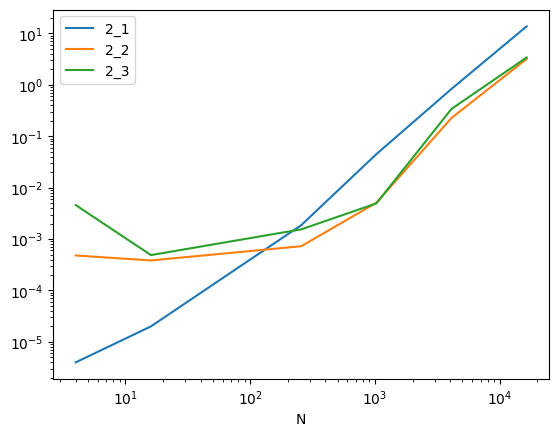

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part2.csv',header=0,names=['name','nb_threads','N','M','nrepeats','runtime'],dtype={
                     'name' : str,
                     'nb_threads':int,
                     'N': int,
                     'M': int,
                     'nrepeats' : int,
                     'runtime' : float
                 })


for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_1 sequential"]
    
    # mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    # plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps], label=f'{num_steps} sequential')
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


df_group = df.groupby('name')
plt.yscale('log')
plt.xscale('log')
df.set_index('N', inplace=True)
df_group['runtime'].plot(legend=True)